In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
import numpy as np
from numpy import polyfit
from scipy import stats
import RegscorePy as rp
from numpy import sqrt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import itertools
import chow_test
from pprint import pprint

from statistics import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('./data/RTS-history-USA.csv', parse_dates=True, index_col='Date')
series = Model(np.array([i for i in df.Open[::25]]))

### Сам график и сглаживания

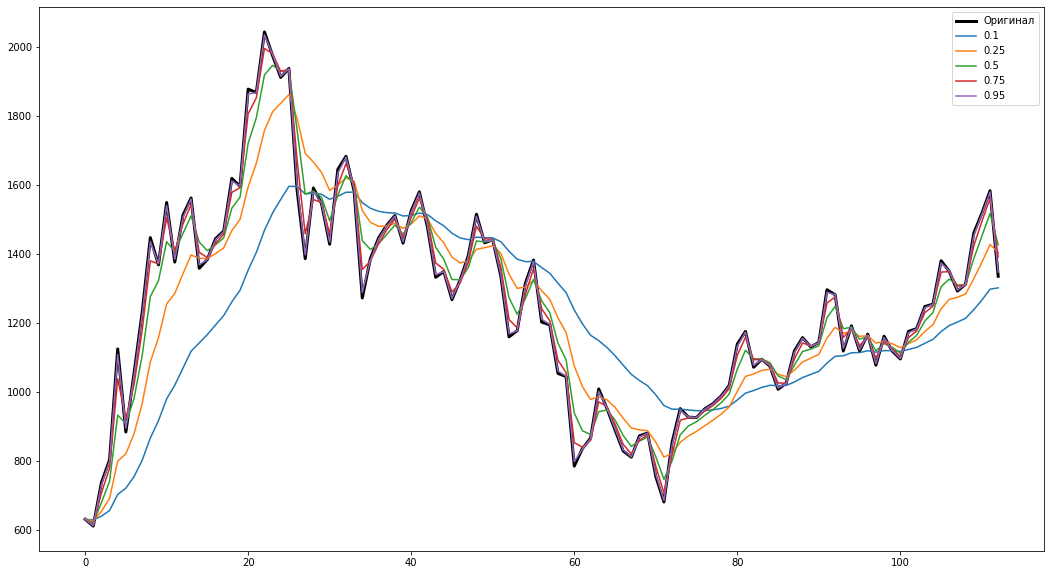

In [3]:
plt.figure(figsize=(18, 10))
draw(series, label='Оригинал', color='000', linewidth=3)
for a in [.1, .25, .5, .75, .95]:
    result = series.exponential_smoothing(a)
    draw(result, label=str(a))
plt.legend()
plt.show()

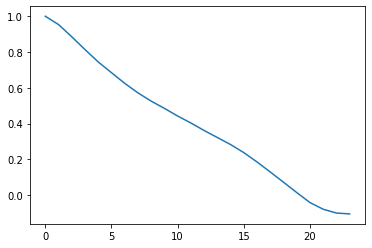

In [4]:
draw(series.exponential_smoothing(.5).many_acf(1, 25));

### Тест фуллера на стационарность ряда

In [5]:
series.fuller_test()

(-2.670316461994629,
 0.07931716496293206,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1212.2077258437034)

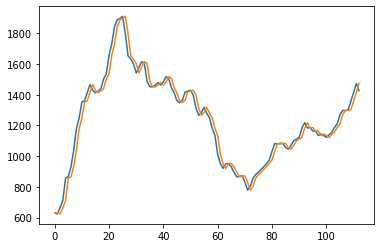

In [6]:
draw(series.exponential_smoothing(.35));
draw(list(SimpleExpSmoothing(df[::25]).fit(smoothing_level=.35, optimized=False).fittedvalues))

### Поиск и отображение тренда графика

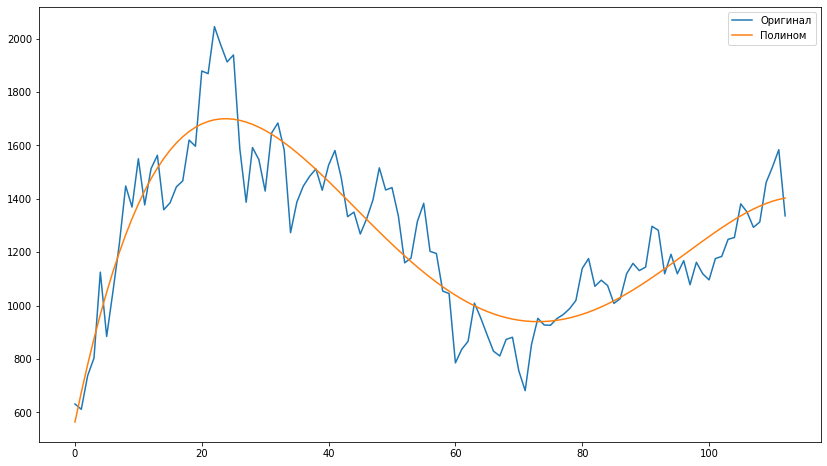

In [7]:
series_trend = series.trend(4)
plt.figure(figsize=(14, 8))
draw(series, label='Оригинал')
draw(series_trend, label='Полином')
plt.legend()
plt.show()

### Расчет КФ детерминации

In [9]:
series.determination_kf(4)

0.805586569565061

### Скорректированный КФ детерм

In [10]:
series.adjusted_determination_kf(4)

0.8002357412044664

### Значимость КФ автокорреляции 2-го порядка

In [11]:
_kf = series.exponential_smoothing(.5).acf(2)
print(_kf / (1-_kf**2/(len(series)-2))**.5)
del _kf

0.9574925278477555


### Декомпозиция

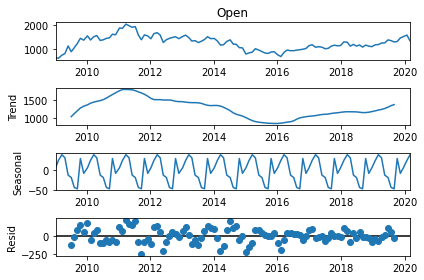

In [12]:
import statsmodels.api as sm

_df = df.copy()
_df.Open[::25].interpolate(inplace=True)

sm.tsa.seasonal_decompose(_df.Open[::25], period=10).plot()
del _df

### Нахождение остатков после вычитания тренда

In [13]:
series_remains = series - series_trend

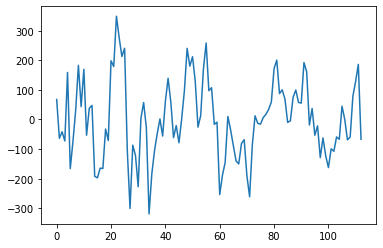

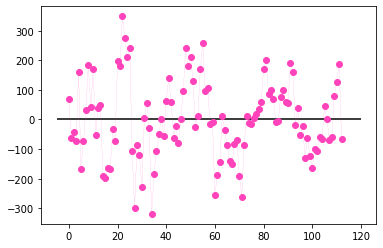

In [14]:
draw(series_remains);
plt.show()
ax = plt.subplot()
draw(series_remains, marker='o', color='#f4b', linewidth=.1);
ax.hlines(0, -5, 120);

### Критерий Фишера для уравнения тренда 

In [15]:
series.fisher(4)

150.55361810849305

## Значимость КФ регрессии по Стьюденту

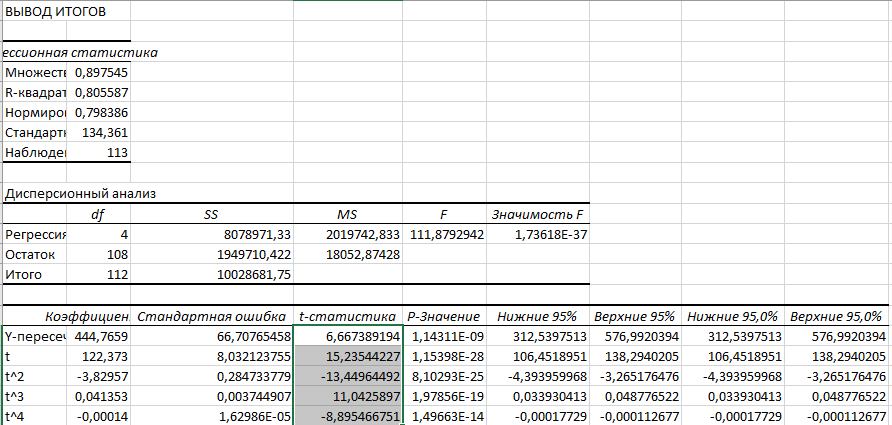

### Критерий Шварца

In [16]:
series.bic(series_trend)

9.964980051513505

### Критерий Акаике

In [17]:
series.aic(series_trend)

9.84429917457933

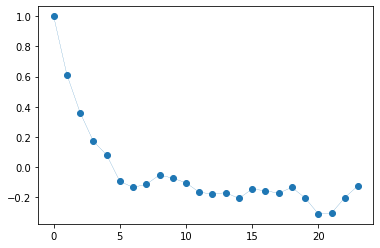

In [18]:
draw(series_remains.many_acf(1,25), marker='o', linewidth=.2);

### Критерий Жакка-Бера на нормальность распределения

In [19]:
stats.jarque_bera(series_remains)

(0.5095735668305718, 0.7750817406258271)

### РС критерий на нормальность распределения

In [20]:
(series_remains.max() - series_remains.min()) / ((series_remains**2).sum()/len(series)-1)**.5

5.085495701916399

### Тест Дарбина Уотсона на автокорреляцию

In [21]:
# Сравнить с таблицей!

In [22]:
series_remains.durbin_watson_test()

0.7705080573236872

### Тест на значимость КФ автокорреляции

In [23]:
_kf = series_remains.acf(2)
print(sqrt((_kf**2)/(1-_kf**2)*(len(series_remains)-2)))
del _kf

8.162090679749317


### Тест на равенство средних

In [24]:
stats.ttest_ind(series[:60], series[60:])

Ttest_indResult(statistic=6.430267317147217, pvalue=3.3086141740613716e-09)

In [25]:
# Поскольку у нас p-value очень мало, то гипотеза h0 - о равенстве средних отвергается

In [26]:
_p1 = series_remains[:55]
_p2 = series_remains[55:]
print(abs(_p1.mean() - _p2.mean()) / sqrt(np.var(_p1)/len(_p1) + np.var(_p2)/len(_p2)))
del _p1, _p2

0.7148925714768324


### Тест на гетероскедастичность (Гольфельд Квандт)

### ARIMA на остатки

ARIMA : 100%|██████████| 1/1 [00:36<00:00, 36.52s/ fit]


((7, 0, 8), 9.33340074758108)

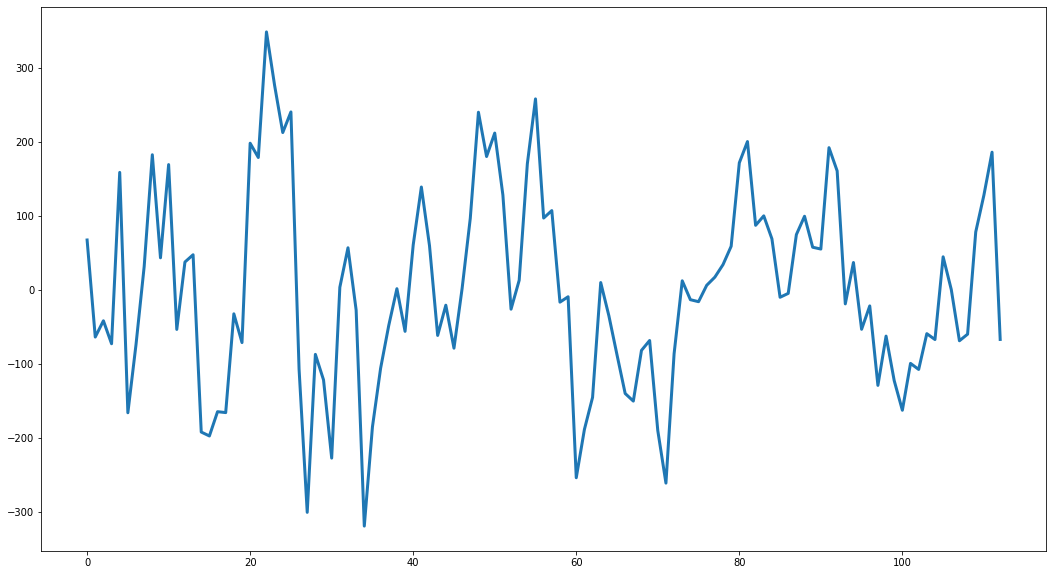

In [27]:
plt.figure(figsize=(18, 10))
draw(series_remains, label='Orig', linewidth=3)

# 7 0 8 - TOP
arima_by_series_remains_model, arima_by_series_remains_fitted_model = \
    Arima.find_optimal_model_by_order(series_remains, 7, 0, 8)
arima_by_series_remains_fitted_model.order, arima_by_series_remains_fitted_model.aic

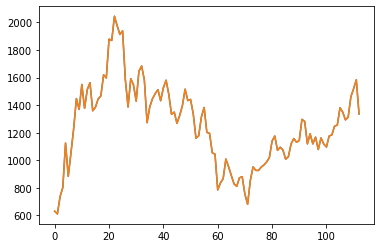

In [31]:
draw(series)
draw(series_trend + arima_by_series_remains_fitted_model.fittedvalues + arima_by_series_remains_fitted_model.resid);

In [27]:
arima_by_series_remains_fitted_model.arparams

array([ 0.91147226,  0.2277196 , -0.4282041 ,  0.17270712,  0.04720058,
        0.51243451, -0.61617799])

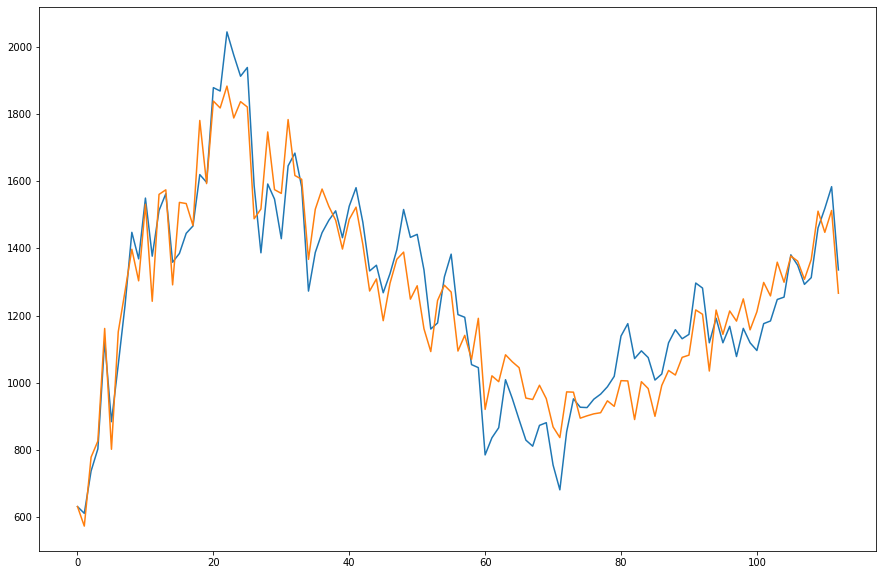

In [28]:
plt.figure(figsize=(15, 10))
draw(series);
draw(series_trend + arima_by_series_remains_fitted_model.resid);

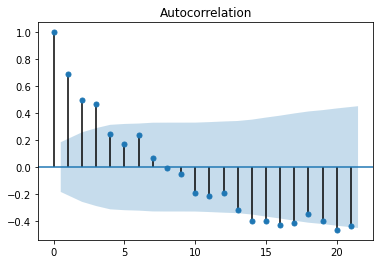

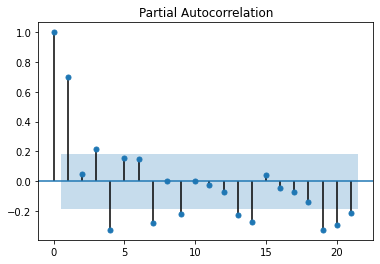

In [29]:
plot_acf(series_remains - arima_by_series_remains_fitted_model.resid)
plot_pacf(series_remains - arima_by_series_remains_fitted_model.resid);

###  Q-test Льюинга Бокса для проверки гипотезы о случайности остатков

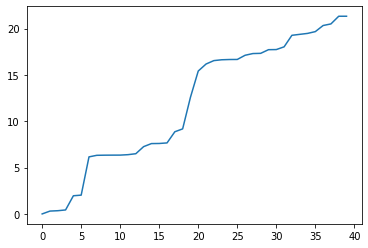

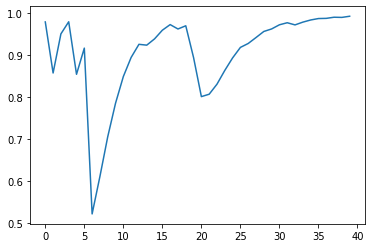

In [30]:
_q_test = acf(arima_by_series_remains_fitted_model.resid, qstat=True, fft=False)
_q_df = pd.DataFrame({'Q-stat': _q_test[1], 'p-value': _q_test[2]})
_q_df['Q-stat'].plot()
plt.show()
_q_df['p-value'].plot();
del _q_test, _q_df

### Тест Дики Фуллера на стационарность остатков

In [31]:
_test_df = series_remains.fuller_test()
if _test_df[0] > _test_df[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
pprint(_test_df)
del _test_df

Ряд стационарен
(-5.130422100748794,
 1.217307664803825e-05,
 0,
 112,
 {'1%': -3.4901313156261384,
  '10%': -2.5807296460459184,
  '5%': -2.8877122815688776},
 1197.077681342571)


## Поскольку все значения p-value больше 0.05, это свидетельствует о том, что гипотеза об отсутствии автокорреляции не отвергается (на уровне значимости 5%) 

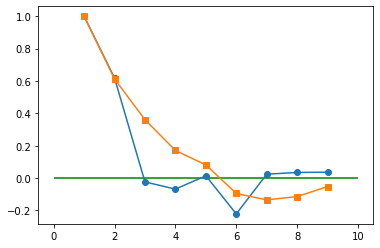

In [32]:
ax = plt.subplot()
draw(range(1, 10), series_remains.many_pacf(1, 10), marker='o', label='PACF')
draw(range(1, 10), series_remains.many_acf(1, 10), marker='s')
ax.hlines(0, 0, 10, color='green')
plt.show();

### Тесты на гомоскедантичность (p-value < 0.05 - гетероскедантичность?)

In [33]:
print(series_remains.barlett())
print(series_remains.levene())

BartlettResult(statistic=169.41630151628857, pvalue=9.923235819367831e-39)
LeveneResult(statistic=96.43696551179367, pvalue=3.69259124387947e-19)


In [34]:
arima_by_series_remains_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:                     ARMA(7, 8)   Log Likelihood                -669.769
Method:                       css-mle   S.D. of innovations             83.560
Date:                Fri, 13 Mar 2020   AIC                           1373.538
Time:                        23:23:20   BIC                           1419.904
Sample:                             0   HQIC                          1392.353
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1611      0.743     -0.217      0.828      -1.617       1.295
ar.L1.y        0.9115      0.140      6.509      0.000       0.637       1.186
ar.L2.y        0.2277      0.188      1.213      0.225      -0.140       0.596
ar.L3.y       -0.4282      0.131     -3.264      0.001      -0.685      -0.171
ar.L4.y        0.1727      0.156      1.106      0.269      -0.133       0.479
ar.L5.y        0.0472      0.171      0.276      0.782      -0.288       0.382
ar.L6.y        0.5124      0.139      3.699      0.000       0.241       0.784
ar.L7.y       -0.6162      0.086     -7.177      0.000      -0.784      -0.448
ma.L1.y       -0.5102      0.164     -3.106      0.002      -0.832      -0.188
ma.L2.y       -0.5246      0.133     -3.952      0.000      -0.785      -0.264
ma.L3.y        0.0106      0.090      0.118      0.906      -0.166       0.187
ma.L4.y        0.1210      0.067      1.812      0.070      -0.010       0.252
ma.L5.y       -0.2904      0.076     -3.802      0.000      -0.440      -0.141
ma.L6.y       -0.8642      0.080    -10.861      0.000      -1.020      -0.708
ma.L7.y        0.7901      0.128      6.150      0.000       0.538       1.042
ma.L8.y        0.2679      0.144      1.857      0.063      -0.015       0.551
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0002           -0.0000j            1.0002           -0.5000
AR.2           -0.6391           -0.9709j            1.1623           -0.3426
AR.3           -0.6391           +0.9709j            1.1623            0.3426
AR.4            0.5372           -0.9118j            1.0582           -0.1653
AR.5            0.5372           +0.9118j            1.0582            0.1653
AR.6            1.0178           -0.1914j            1.0356           -0.0296
AR.7            1.0178           +0.1914j            1.0356            0.0296
MA.1            1.0005           -0.0010j            1.0005           -0.0002
MA.2            1.0005           +0.0010j            1.0005            0.0002
MA.3            0.4710           -0.8821j            1.0000           -0.1719
MA.4            0.4710           +0.8821j            1.0000            0.1719
MA.5           -0.5814           -0.8136j            1.0000           -0.3487
MA.6           -0.5814           +0.8136j            1.0000            0.3487
MA.7           -1.0000           -0.0000j            1.0000           -0.5000
MA.8           -3.7295           -0.0000j            3.7295           -0.5000
-----------------------------------------------------------------------------
"""

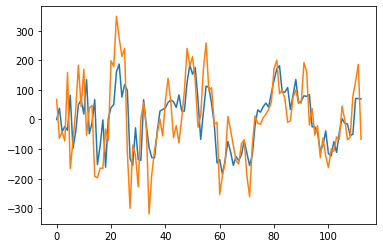

In [35]:
draw(series_remains - arima_by_series_remains_fitted_model.resid);
draw(series_remains);

# ARIMA на исходные данные 

In [36]:
arima_by_series_model, arima_by_series_fitted_model = Arima.find_optimal_model_by_order(series, 5, 1, 6)
arima_by_series_fitted_model.aic

ARIMA : 100%|██████████| 1/1 [00:11<00:00, 11.53s/ fit]


9.636000457985322

In [37]:
arima_by_series_fitted_model.predict()[0]

8.088514405259989

In [38]:
# resid = np.append(fitted_model2.resid, fitted_model2.predict()[0])

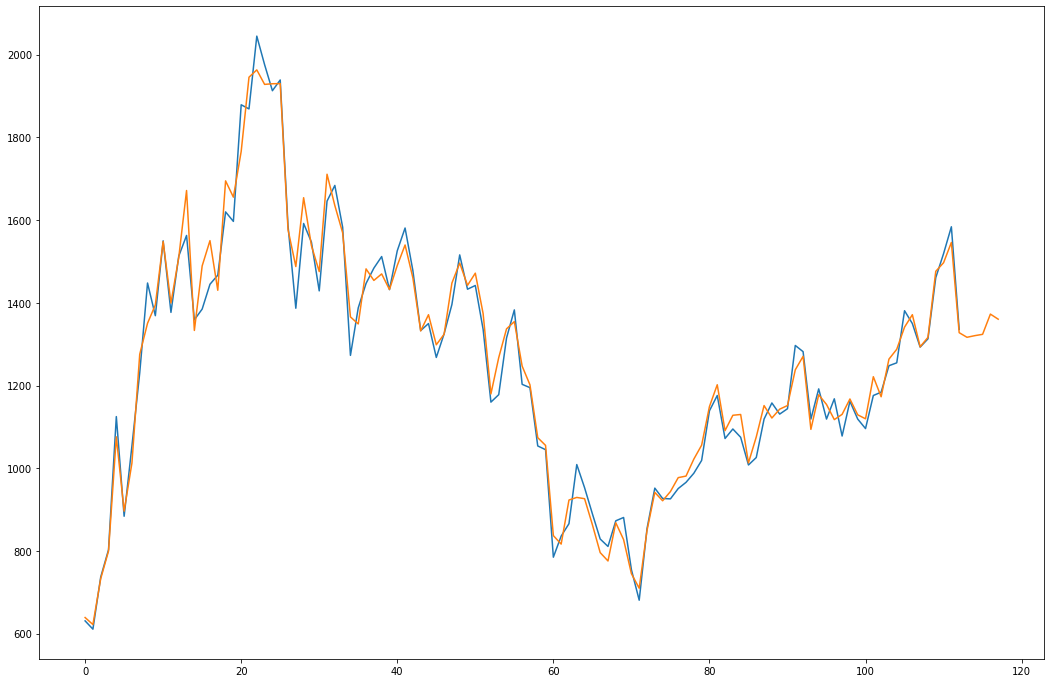

In [39]:
plt.figure(figsize=(18, 12))
draw(series);
resid = Model(
    series[1:] - arima_by_series_fitted_model.resid).append(series[-1]-arima_by_series_fitted_model.predict()[0]
)
for i in range(5):
    resid.append(
        resid[-1]-arima_by_series_fitted_model.predict()[i+1], inplace=True)
draw(resid)
plt.show()

#### Остатки после тренда и остатки после аримы

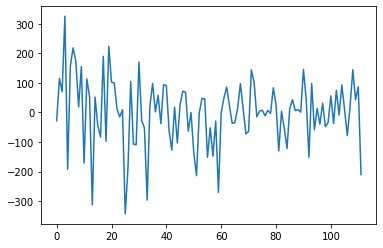

In [40]:
draw(arima_by_series_fitted_model.resid);

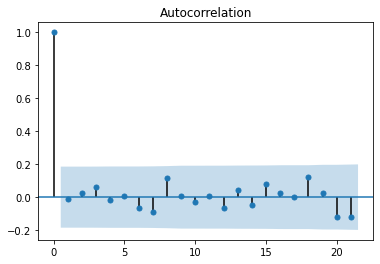

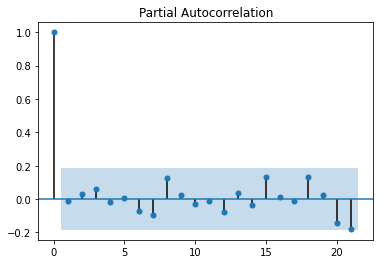

In [41]:
plot_acf(arima_by_series_fitted_model.resid);
plot_pacf(arima_by_series_fitted_model.resid);

##### Результат вроде как белый шум

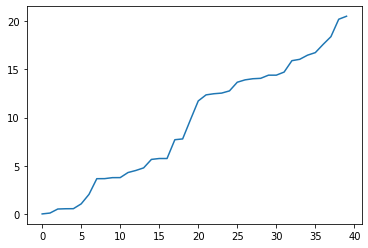

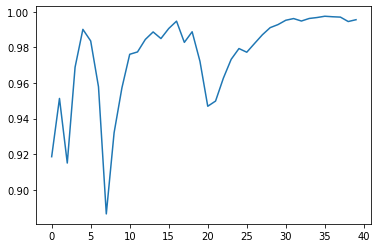

In [42]:
_q_test = Model(arima_by_series_fitted_model.resid).acf(lag=40, qstat=True, fft=False)
_q_df = pd.DataFrame({'Q-stat': _q_test[1], 'p-value': _q_test[2]})
_q_df['Q-stat'].plot()
plt.show()
_q_df['p-value'].plot();
del _q_test, _q_df

# 3-я Глава

### Тест CHOW

CHOW : 100%|██████████| 12769/12769 [00:08<00:00, 1485.55 test/s]


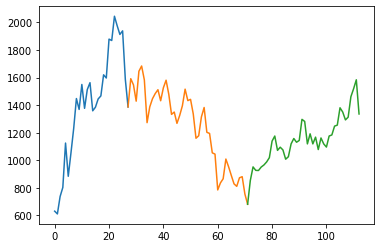

In [43]:
draw(series.cut_by_chow_test(arbitrarily=3));

### Результаты теста ЧОУ

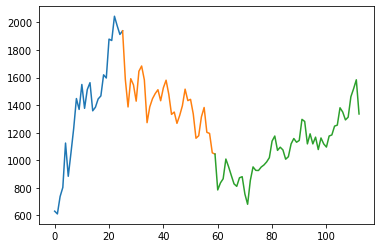

In [44]:
partial_series = PartialModel(series[:26], series[26:60], series[60:])
partial_series_trend = PartialModel(*partial_series.each_trend(3))
partial_series_remains = PartialModel(
    partial_series.p1-partial_series_trend.p1,
    partial_series.p2-partial_series_trend.p2,
    partial_series.p3-partial_series_trend.p3
)
draw(partial_series)

### Первый кусок

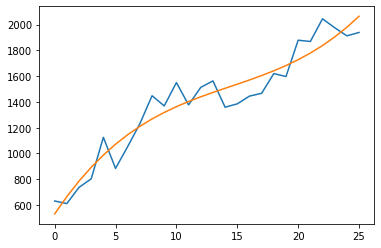

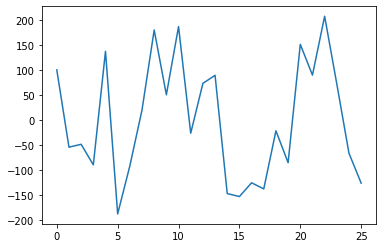

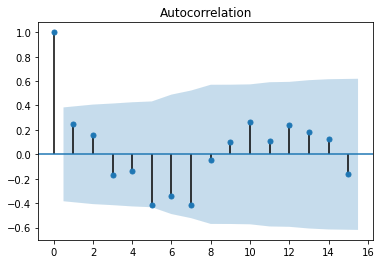

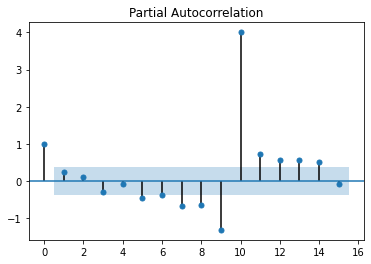

In [45]:
draw(partial_series.p1)
draw(partial_series_trend.p1);
plt.show()
draw(partial_series_remains.p1);
plot_acf(partial_series_remains.p1);
plot_pacf(partial_series_remains.p1);

### Второй кусок

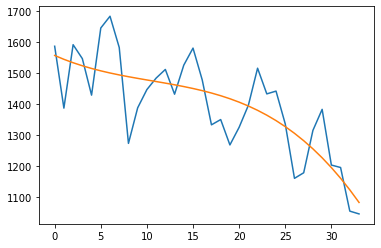

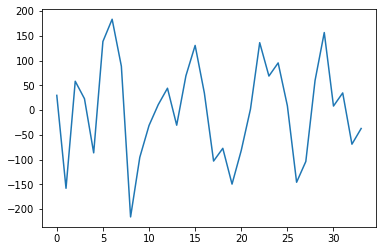

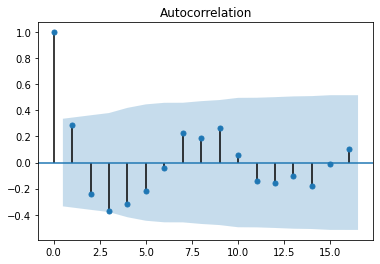

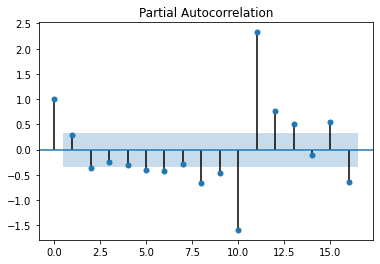

In [46]:
draw(partial_series.p2)
draw(partial_series_trend.p2);
plt.show()
draw(partial_series_remains.p2);
plot_acf(partial_series_remains.p2);
plot_pacf(partial_series_remains.p2);

### Третий кусок

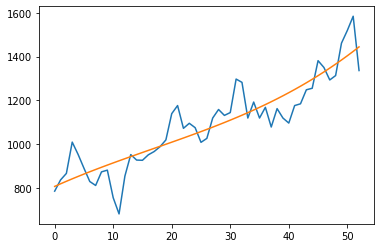

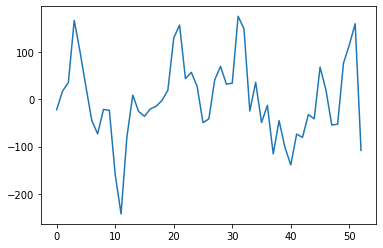

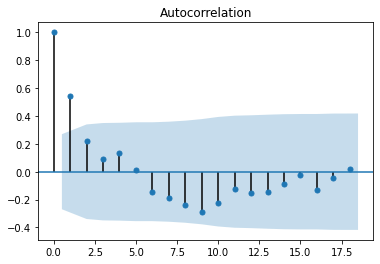

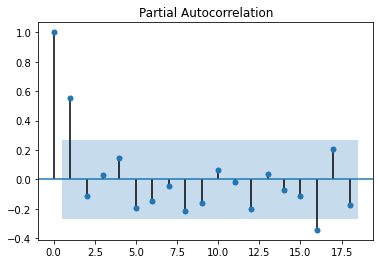

In [47]:
draw(partial_series.p3)
draw(partial_series_trend.p3);
plt.show()
draw(partial_series_remains.p3);
plot_acf(partial_series_remains.p3);
plot_pacf(partial_series_remains.p3);

### Общий кусочный тренд

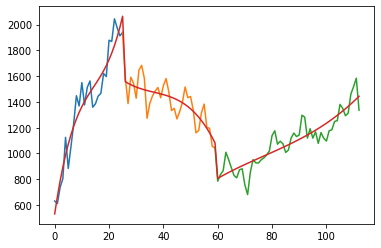

In [48]:
draw(partial_series)
draw(partial_series_trend.join());

### Остатки 

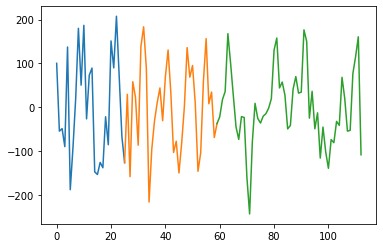

In [49]:
draw(partial_series - partial_series_trend);

### КФ детерминации кусочного тренда

In [50]:
determination = partial_series.join().partial_determination_kf(partial_series_trend.join())

In [51]:
model1, fitted1 = Arima.find_optimal_model_by_order(partial_series_remains.p1, range(3), (0, 1), range(4))
model2, fitted2 = Arima.find_optimal_model_by_order(partial_series_remains.p2, range(3), (0, 1), range(4))
model3, fitted3 = Arima.find_optimal_model_by_order(partial_series_remains.p3, range(3), (0, 1), range(4))

print('P1', fitted1.order, fitted1.aic)
print('P2', fitted2.order, fitted2.aic)
print('P3', fitted3.order, fitted3.aic)

partial_series_trend_remains = PartialModel(
    partial_series_trend.p1 + fitted1.seq,
    partial_series_trend.p2 + fitted2.seq,
    partial_series_trend.p3 + fitted3.seq
)
del model1, fitted1, model2, fitted2, model3, fitted3

ARIMA : 100%|██████████| 24/24 [00:02<00:00, 10.96 fit/s]

P1 (1, 0, 0) 9.53673115636221
P2 (2, 0, 1) 8.870756983657554
P3 (0, 0, 2) 8.559775237775487


### Тренд +АРИМА

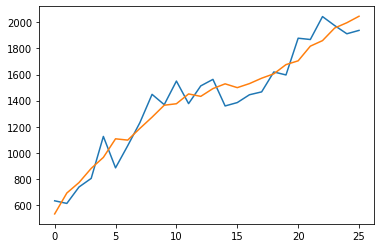

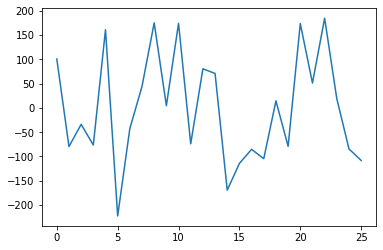

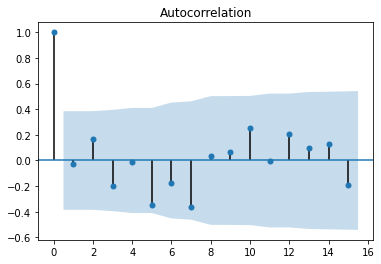

In [52]:
draw(partial_series.p1)
draw(partial_series_trend_remains.p1)
plt.show()
draw(partial_series.p1 - partial_series_trend_remains.p1)
plt.show()
plot_acf(partial_series.p1 - partial_series_trend_remains.p1);

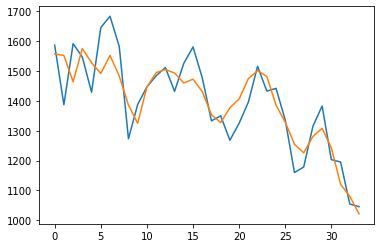

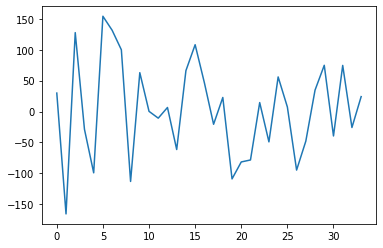

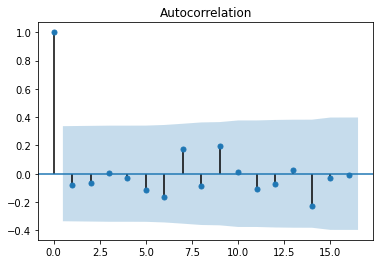

In [53]:
draw(partial_series.p2)
draw(partial_series_trend_remains.p2)
plt.show()
draw(partial_series.p2 - partial_series_trend_remains.p2)
plt.show()
plot_acf(partial_series.p2 - partial_series_trend_remains.p2);

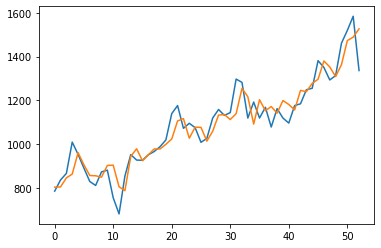

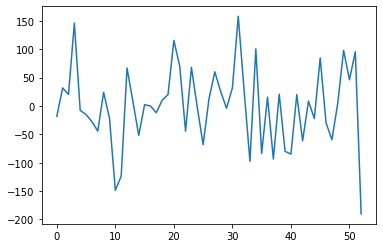

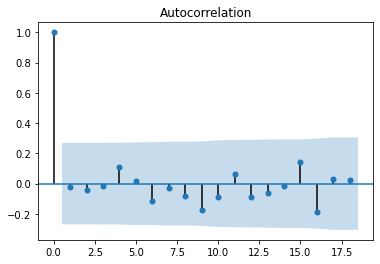

In [54]:
draw(partial_series.p3)
draw(partial_series_trend_remains.p3)
plt.show()
draw(partial_series.p3 - partial_series_trend_remains.p3)
plt.show()
plot_acf(partial_series.p3 - partial_series_trend_remains.p3);

### Склеил тренд + АРИМА (для каждого куска)

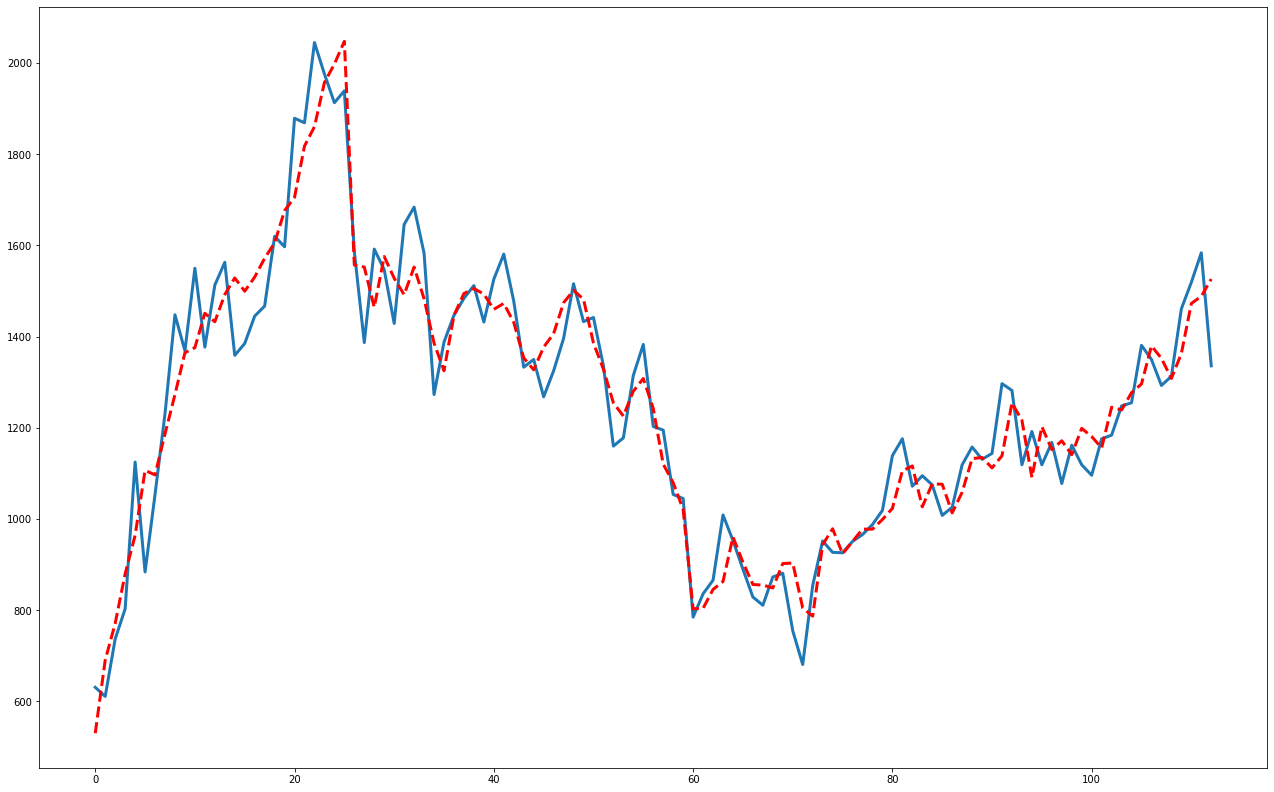

In [55]:
plt.figure(figsize=(22, 14))
draw(partial_series.join(), linewidth=3)
draw(partial_series_trend_remains.join(), 'r--', linewidth=3);

In [56]:
series.partial_determination_kf(partial_series_trend_remains.join())

0.9302611344696466

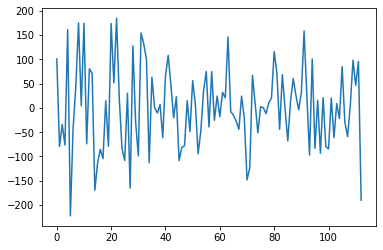

In [57]:
draw(series-partial_series_trend_remains.join());

### АРИМА на остатки всей модели

In [58]:
arima_by_partial_series_remains_model, arima_by_partial_series_remains_fitted_model = \
    Arima.find_optimal_model_by_order(
    (partial_series - partial_series_trend).join(), range(3), range(2), range(3)
)
arima_by_partial_series_remains_fitted_model.aic

ARIMA : 100%|██████████| 18/18 [00:02<00:00,  8.29 fit/s]


8.947437013897199

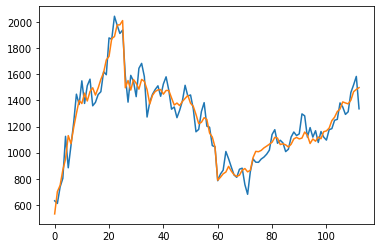

In [59]:
draw(series)
draw(partial_series_trend.join()+arima_by_partial_series_remains_fitted_model.seq);

# ВЫВОДЫ

### Тренд(3) + АРИМА на остатки

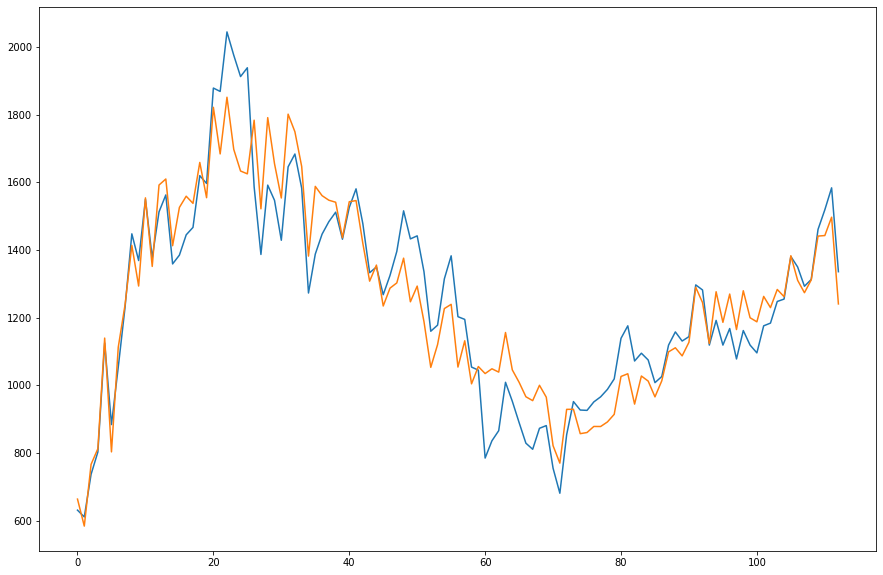

In [60]:
plt.figure(figsize=(15, 10))
draw(series);
draw(series_trend + arima_by_partial_series_remains_fitted_model.resid);

In [61]:
print('MAPE:', series.mape(series_trend+arima_by_series_remains_fitted_model.resid))
print('MAE:', series.mae(series_trend+arima_by_series_remains_fitted_model.resid))

MAPE: 6.905785740607465
MAE: 80.92473963836783


### Арима на исходные данные

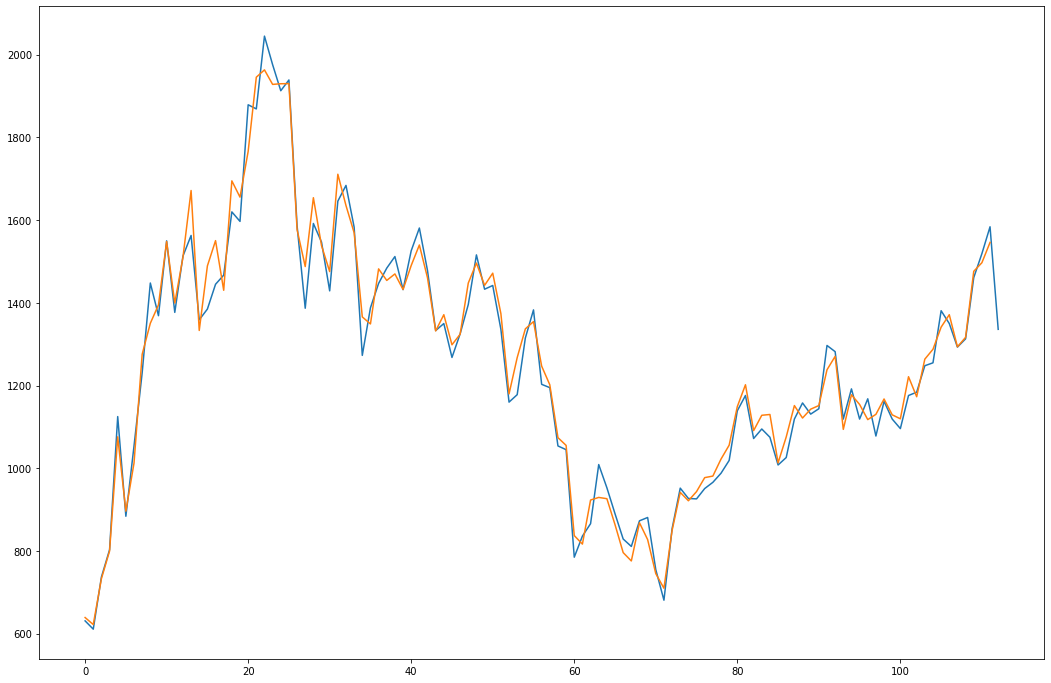

In [62]:
plt.figure(figsize=(18, 12))
draw(series);
draw(series[1:] - arima_by_series_fitted_model.resid);
plt.show()

In [63]:
print('MAPE:', series[:-1].mape(series[1:] - arima_by_series_fitted_model.resid))
print('MAE:', series[:-1].mae(series[1:] - arima_by_series_fitted_model.resid))

MAPE: 2.646247131969268
MAE: 33.14770625224696


### Кусочный тренд + арима на остатки всей модели

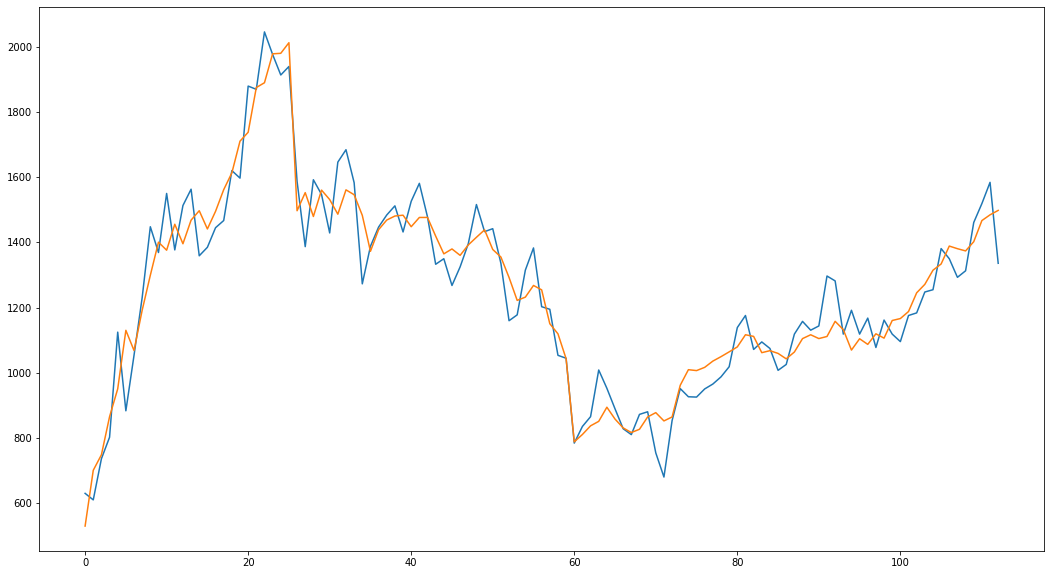

In [64]:
plt.figure(figsize=(18, 10))
draw(series)
draw(partial_series_trend.join()+arima_by_partial_series_remains_fitted_model.seq);

In [65]:
print('MAPE:', series.mape(partial_series_trend.join()+arima_by_partial_series_remains_fitted_model.seq))
print('MAE:', series.mae(partial_series_trend.join()+arima_by_partial_series_remains_fitted_model.seq))

MAPE: 5.618882472428915
MAE: 67.47284580359693
